<a href="https://colab.research.google.com/github/Y00NSJ/RL/blob/main/REINFORCE/implement/cartpole_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# authored-by : https://github.com/multicore-it/rl/blob/main/codes/cartpole_reinforce.ipynb

import numpy as np
np.bool8 = np.bool_
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam, SGD
import gym
import os

import random as rand


class Agent(object):
    def __init__(self):
      # 프로그램 동작 설정
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.value_size = 1     # 보상값 크기

      # 모델 설정
        self.node_num = 12
        self.learning_rate = 0.0005
        self.epochs_cnt = 5
        self.model = self.build_model()

      # 학습 설정
        self.discount_rate = 0.95
        self.penalty = -10

      # 반복 설정(에피소드 수)
        self.episode_num = 500

      # 학습 모니터링 설정
        self.moving_avg_size = 20
        self.reward_list= []
        self.count_list = []
        self.moving_avg_list = []

      # 데이터 수집 환경: 1에피동안 수집된 데이터 저장할 변수, 행동 결정 모델 호출 시 필요한 dummy
        self.states, self.action_matrixs, self.action_probs, self.rewards = [],[],[],[]
        self.DUMMY_ACTION_MATRIX, self.DUMMY_REWARD = np.zeros((1,1,self.action_size)), np.zeros((1,1,self.value_size))


    class MyModel(tf.keras.Model):      # 사용자 정의 비용 함수 사용하기 위해 상속 및 재정의
        def train_step(self, data):     # 사용자 정의 비용 함수: 인공신경망은 이를 감소시키는 방향으로 학습 진행
            in_datas, out_actions = data
            states, action_matrix, rewards = in_datas[0], in_datas[1], in_datas[2]

            with tf.GradientTape() as tape: # 편미분하면서 gradient(=기울기) 구하기 위함(연산 기록중)
              # 행동 예측: state를 인공신경망에 입력해 정책(각 행동(좌/우) 할 확률) 출력
                y_pred = self([states, action_matrix, rewards], training=True)
              # 확률 계산: n번 정책을 [n]의 확률로 선택
                action_probs = K.sum(action_matrix*y_pred, axis=-1)
              # 비용 함수
                loss = -K.log(action_probs)*rewards

          # 모델 가중치
            trainable_vars = self.trainable_variables
          # gradient 호출 및 적용
            gradients = tape.gradient(loss, trainable_vars)
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))

            return {"loss": tf.reduce_mean(loss)}

    def build_model(self):  # 모델 생성
        input_states = Input(shape=(1,self.state_size), name='input_states')
        input_action_matrixs = Input(shape=(1,self.action_size), name='input_action_matrixs')
        input_rewards = Input(shape=(1,self.value_size), name='input_rewards')

      # network 구성
        x = (input_states)
        x = Dense(self.node_num, activation='tanh')(x)
        # 행동별 정책에 대한 확률이 출력으로 사용됨 => 활성 함수로 softmax 활용
        out_actions = Dense(self.action_size, activation='softmax', name='output')(x)

        model = self.MyModel(inputs=[input_states, input_action_matrixs, input_rewards], outputs=out_actions)

        model.compile(optimizer=Adam(learning_rate=self.learning_rate))

        model.summary()
        return model

    def train(self): # 1에피 동안 수집한 모든 데이터를 사용해 학습
        for episode in range(self.episode_num):

            state = self.env.reset()
            self.env.max_episode_steps = 500

          # 1에피 간 데이터 수집 -> 클래스 변수에 리스트 형식으로 저장
            count, reward_tot = self.make_memory(episode, state)
          # 수집된 데이터 기반으로 인공신경망 모델 학습
            self.train_mini_batch()
            self.clear_memory()

            if count < 500:
                reward_tot = reward_tot-self.penalty

            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list,self.moving_avg_size))

            if(episode % 10 == 0):
                print("episode:{}, moving_avg:{}, rewards_avg:{}".format(episode, self.moving_avg_list[-1], np.mean(self.reward_list)))

        self.save_model()

    def make_memory(self, episode, state):  # 프로그램 실행하며 경험 수집
        reward_tot = 0
        count = 0
        reward = np.zeros(self.value_size)
        action_matrix = np.zeros(self.action_size)
        done = False
        while not done:
            count+=1

            state_t = np.reshape(state,[1, 1, self.state_size])
            action_matrix_t = np.reshape(action_matrix,[1, 1, self.action_size])

            action_prob = self.model.predict([state_t, self.DUMMY_ACTION_MATRIX, self.DUMMY_REWARD], verbose=0)

            action = np.random.choice(self.action_size, 1, p=action_prob[0][0])[0]
            action_matrix = np.zeros(self.action_size)
            action_matrix[action] = 1

            state_next, reward, done, _ = self.env.step(action)

            if count < 500 and done:
                reward = self.penalty

            self.states.append(np.reshape(state_t, [1,self.state_size]))
            self.action_matrixs.append(np.reshape(action_matrix, [1,self.action_size]))
            self.action_probs.append(np.reshape(action_prob, [1,self.action_size]))
            self.rewards.append(reward)

            reward_tot += reward
            state = state_next
        return count, reward_tot

    def clear_memory(self):
        self.states, self.action_matrixs, self.action_probs, self.rewards = [],[],[],[] #clear memory


    def make_discount_rewards(self, rewards):   # 실행 시점별로 discounted 반환값 계산
        discounted_rewards = np.zeros(np.array(rewards).shape)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.discount_rate + rewards[t]
            discounted_rewards[t] = running_add

        return discounted_rewards

    def train_mini_batch(self):                 # 수집된 데이터 활용해 모델 학습
        if len(self.states) == 0:
            #print("No data collected. Skipping batch.")
            return
      # 1. 단계별 수집된 보상으로 할인된 반환값 계산
        discount_rewards = np.array(self.make_discount_rewards(self.rewards)).reshape(-1,1,1)
      # 2. 각 데이터를 학습 가능한 형태로 성형
        #discount_rewards_t = np.reshape(discount_rewards, [len(discount_rewards),1,1]) # 반환값
        # Agent 클래스 변수
        states_t = np.array(self.states).reshape(-1, 1, self.state_size)
        action_matrixs_t = np.array(self.action_matrixs).reshape(-1, 1, self.action_size)
        action_probs_t = np.array(self.action_probs).reshape(-1, self.action_size)

        #print(f"states: {states_t.shape}, actions: {action_matrixs_t.shape}, rewards: {discount_rewards.shape}, probs: {action_probs_t.shape}")
        #print("types:", type(states_t), type(action_matrixs_t), type(discount_rewards), type(action_probs_t))

        if (
            states_t.shape[0] == 0 or
            action_matrixs_t.shape[0] == 0 or
            discount_rewards.shape[0] == 0 or
            action_probs_t.shape[0] == 0
        ):
            #print("One or more inputs are empty. Skipping batch.")
            return

      # 상태, 행동 매트릭스, 반환값 입력; 목표함수로는 행동별 확률을 입력
        self.model.fit(x=[states_t, action_matrixs_t, discount_rewards],
                       y=action_probs_t,
                       epochs=self.epochs_cnt,
                       verbose=0)

    def moving_avg(self, data, size=10):
        if len(data) > size:
            c = np.array(data[len(data)-size:len(data)])
        else:
            c = np.array(data)
        return np.mean(c)

    def save_model(self):
        os.makedirs("./model", exist_ok=True)
        self.model.save("./model/reinforce.keras")
        print("*****end learing")

if __name__ == "__main__":
    agent = Agent()
    agent.train()



/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_states (InputLayer) │ (None, 1, 4)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 12)          │             60 │ input_states[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_action_matrixs      │ (None, 1, 2)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_rewards             │ (None, 1, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1, 2)           │             26 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 86 (344.00 B)

 Trainable params: 86 (344.00 B)

 Non-trainable params: 0 (0.00 B)

episode:0, moving_avg:20.0, rewards_avg:19.0
episode:10, moving_avg:20.636363636363637, rewards_avg:19.636363636363637
episode:20, moving_avg:24.1, rewards_avg:22.904761904761905
episode:30, moving_avg:30.2, rewards_avg:25.806451612903224
episode:40, moving_avg:29.5, rewards_avg:25.634146341463413
episode:50, moving_avg:27.8, rewards_avg:26.19607843137255
episode:60, moving_avg:29.8, rewards_avg:26.672131147540984
episode:70, moving_avg:36.1, rewards_avg:28.704225352112676
episode:80, moving_avg:42.4, rewards_avg:30.308641975308642
episode:90, moving_avg:47.55, rewards_avg:32.62637362637363
episode:100, moving_avg:51.7, rewards_avg:34.34653465346535
episode:110, moving_avg:51.5, rewards_avg:35.846846846846844
episode:120, moving_avg:55.75, rewards_avg:37.71900826446281
episode:130, moving_avg:58.1, rewards_avg:39.091603053435115
episode:140, moving_avg:58.05, rewards_avg:40.46099290780142
episode:150, moving_avg:56.6, rewards_avg:41.27814569536424
episode:160, moving_avg:52.3, rewards_

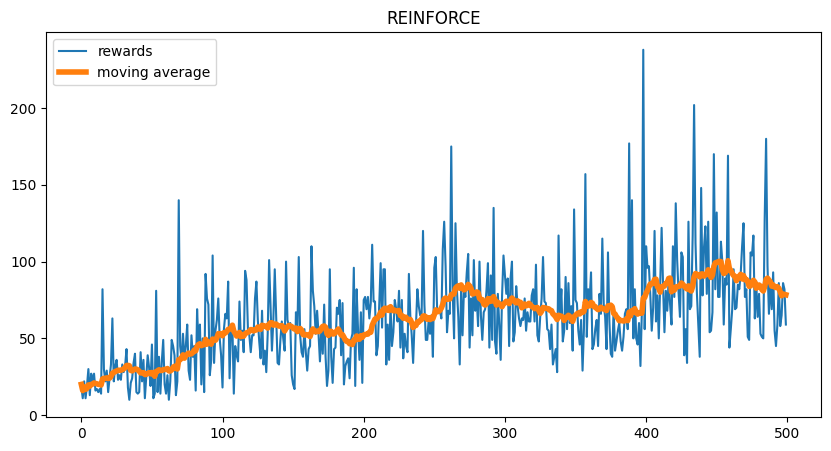

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label='rewards')
plt.plot(agent.moving_avg_list, linewidth=4, label='moving average')
plt.legend(loc='upper left')
plt.title('REINFORCE')
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np

y_pred = np.array([[0.6,0.4],
                   [0.3,0.7]])
action_matrix = np.array([[1,0],
                          [0,1]])

action_probs = K.sum(action_matrix*y_pred, axis=-1)
print("*action_probs:", action_probs)

*action_probs: tf.Tensor([0.6 0.7], shape=(2,), dtype=float64)


In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np

x = tf.constant([1.0, 2.0, 3.0])

with tf.GradientTape() as tape:
    tape.watch(x)
    y = (x*x)
z = tape.gradient(y, x)
print(z)

tf.Tensor([2. 4. 6.], shape=(3,), dtype=float32)


In [ ]:
b= zip([1, 2, 3], [4, 5, 6])
c = list(b)
print(c)

[(1, 4), (2, 5), (3, 6)]


In [ ]:
import numpy as np

acton_prob = [0.7, 0.3]
for i in range(10):
    d = np.random.choice(2, 1, p=acton_prob)[0]
    print(d, end=', ')

0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 

In [ ]:
a = [1,2,3,4,5]
for t in reversed(range(0, len(a))):
    print(t, end=', ')

4, 3, 2, 1, 0, 